In [1]:
# === Bibliotecas padrão ===
from pathlib import Path
import importlib

# === Bibliotecas de terceiros ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import compute_sample_weight

import joblib

# === Módulos locais ===
import sys
import os

# Caminho absoluto até a pasta src
src_path = r"C:\Users\Camilo_Bica\data_science\consultoria\acelerador_petrobras\notebooks\src"

if src_path not in sys.path:
    sys.path.append(src_path)
    
# Garante que a pasta atual (notebooks/) esteja no sys.path
notebooks_dir = os.path.abspath(os.getcwd())
if notebooks_dir not in sys.path:
    sys.path.append(notebooks_dir)

# Agora importa diretamente SEM prefixo
import leadscore_plot
importlib.reload(leadscore_plot)

from leadscore_plot import (
    plot_comparativo_leads_alunos,
    plot_histograma_leadscore,
    plot_probabilidade_conversao_vs_score
)

# === Configuração de visualização ===
cores = plt.get_cmap('Accent').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

In [2]:
# === Imports
import gspread
from gspread_dataframe import get_as_dataframe
import os
from dotenv import load_dotenv
from google.oauth2 import service_account

# === Carregar variáveis de ambiente
load_dotenv()

# === Autenticação
credenciais_path = os.getenv("GOOGLE_CREDENTIALS_PATH")
scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]
creds = service_account.Credentials.from_service_account_file(
    credenciais_path,
    scopes=scopes
)
client = gspread.authorize(creds)

# === Função para carregar direto do Google Sheets
def carregar_aba(sheet_id, aba_nome="Dados"):
    planilha = client.open_by_key(sheet_id)
    aba = planilha.worksheet(aba_nome)
    df = pd.DataFrame(aba.get_all_records())
    return df

# === IDs fixos das suas planilhas
id_pesquisa_captacao = "1ukLwu8SoP0U3uirB6w1Ca3TPEITY50c558xNUUN3kj4"
id_pesquisa_aluno = "1GDCAa1fiflDIBnRY9rrdY9ghKwS6DPzxIG9FYGZEsQU"

# === Carregar os dados direto da nuvem
df_leads = carregar_aba(id_pesquisa_captacao)
df_alunos = carregar_aba(id_pesquisa_aluno)

# === Garantir cópias para segurança
df_leads = df_leads.copy()
df_alunos = df_alunos.copy()

# === Criar variável target 'comprou'
df_leads["comprou"] = df_leads["email"].isin(df_alunos["email"]).astype(int)

In [3]:
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42078 entries, 0 to 42077
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   data                   42078 non-null  object
 1   email                  42078 non-null  object
 2   idade                  42078 non-null  object
 3   nível                  42078 non-null  object
 4   situação profissional  42078 non-null  object
 5   renda                  42078 non-null  object
 6   escolaridade           42078 non-null  object
 7   duvida                 42078 non-null  object
 8   dificuldade            42078 non-null  object
 9   utm_source             42078 non-null  object
 10  utm_campaign           42078 non-null  object
 11  utm_medium             42078 non-null  object
 12  utm_content            42078 non-null  object
 13  lancamentos            42078 non-null  object
 14  comprou                42078 non-null  int32 
dtypes: int32(1), object

In [4]:
df_leads.drop(columns=['email']).head()

,data,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,utm_source,utm_campaign,utm_medium,utm_content,lancamentos,comprou
0,2025-04-07 0:00:00,33-37,Técnica,Autônomo,De 1.000 a 3.000,Ensino médio completo,O que preciso pra ser aprovado,Tempo,,,,,,0
1,2025-04-07 0:00:00,23-27,Técnica,Desempregado(a),Estou desempregado(a),Ensino superior incompleto,.,Separa material,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_001_ANUNCIO PETRO 01,SSP-L12,0
2,2025-04-07 0:00:00,18-22,Superior,Desempregado(a),Estou desempregado(a),Ensino médio completo,O quão difícil é conseguir passar,Nenhuma,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,SSP-L12,0
3,2025-04-07 0:00:00,28-32,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Em qual lugar do Brasil pode fazer o concurso?,Tempo,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 30D,ADS_001_ANUNCIO PETRO 01,SSP-L12,0
4,2025-04-07 0:00:00,18-22,Técnica,Autônomo,Estou desempregado(a),Ensino médio completo,Se precisa de ensino superior,Nenhuma,,,,,,0


In [5]:
df_alunos.drop(columns=['email']).head()

,data,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,utm_source,utm_campaign,utm_medium,utm_content,lancamentos
0,2025-04-07 0:00:00,18-22,Superior,Funcionário de empresa privada,De 1.000 a 3.000,Ensino superior completo,A quais vagas posso concorrer tendo tecnólogo ...,Tempo,Youtube,,Descricao,,SSP-L12
1,2025-04-07 0:00:00,38-45,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,Tenho o curso técnico em contabilidade servi p...,Memorização,,,,,
2,2025-04-07 0:00:00,28-32,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,Em qual cidade irei fazer o concurso?,Não sei o que estudar,Youtube,,Descricao,,SSP-L12
3,2025-04-07 0:00:00,28-32,Técnica,Desempregado(a),De 1.000 a 3.000,Ensino superior completo,Quando vai sair o edital,Foco,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_007_ANUNCIO PETRO 07,SSP-L12
4,2025-04-07 0:00:00,46-52,Técnica,Funcionário de empresa privada,De 3.000 a 5.000,Nível técnico completo,A prova,Tempo,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_001_ANUNCIO PETRO 01,SSP-L12


In [6]:
colunas_excluir = ["data", "email"]

for col in df_leads.select_dtypes(include=["category", "object"]).columns:
    if col not in colunas_excluir:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_leads[col].value_counts(dropna=False))


====== VARIÁVEL: IDADE ======

idade
23-27         9050
18-22         8466
28-32         7395
38-45         6833
33-37         5988
46-52         3108
53 ou mais    1238
Name: count, dtype: int64

====== VARIÁVEL: NÍVEL ======

nível
Técnica     31799
Superior    10279
Name: count, dtype: int64

====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======

situação profissional
Funcionário de empresa privada                          17719
Autônomo                                                10390
Desempregado(a)                                          9594
Funcionário público                                      2877
Empresário                                                833
Já sou funcionário terceirizado do sistema Petrobras      665
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======

renda
De 1.000 a 3.000         21223
De 3.000 a 5.000          7922
De 0 a 1.000              5369
Estou desempregado(a)     4771
De 5.000 a 10.000         2413
Mais de 10.000             380
Name: count

In [7]:
for col in df_alunos.select_dtypes(include=["category", "object"]).columns:
    if col not in colunas_excluir:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_alunos[col].value_counts(dropna=False))


====== VARIÁVEL: IDADE ======

idade
23-27         50
38-45         39
28-32         35
33-37         32
46-52         24
18-22         17
53 ou mais     6
Name: count, dtype: int64

====== VARIÁVEL: NÍVEL ======

nível
Técnica     171
Superior     32
Name: count, dtype: int64

====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======

situação profissional
Funcionário de empresa privada                          104
Desempregado(a)                                          41
Autônomo                                                 33
Empresário                                               12
Funcionário público                                      11
Já sou funcionário terceirizado do sistema Petrobras      2
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======

renda
De 1.000 a 3.000         81
De 3.000 a 5.000         59
De 5.000 a 10.000        27
Estou desempregado(a)    22
De 0 a 1.000             11
Mais de 10.000            3
Name: count, dtype: int64

====== VARIÁVEL: ESCOLARIDADE ==

In [8]:
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42078 entries, 0 to 42077
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   data                   42078 non-null  object
 1   email                  42078 non-null  object
 2   idade                  42078 non-null  object
 3   nível                  42078 non-null  object
 4   situação profissional  42078 non-null  object
 5   renda                  42078 non-null  object
 6   escolaridade           42078 non-null  object
 7   duvida                 42078 non-null  object
 8   dificuldade            42078 non-null  object
 9   utm_source             42078 non-null  object
 10  utm_campaign           42078 non-null  object
 11  utm_medium             42078 non-null  object
 12  utm_content            42078 non-null  object
 13  lancamentos            42078 non-null  object
 14  comprou                42078 non-null  int32 
dtypes: int32(1), object

In [9]:
df_alunos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   data                   203 non-null    object
 1   email                  203 non-null    object
 2   idade                  203 non-null    object
 3   nível                  203 non-null    object
 4   situação profissional  203 non-null    object
 5   renda                  203 non-null    object
 6   escolaridade           203 non-null    object
 7   duvida                 203 non-null    object
 8   dificuldade            203 non-null    object
 9   utm_source             203 non-null    object
 10  utm_campaign           203 non-null    object
 11  utm_medium             203 non-null    object
 12  utm_content            203 non-null    object
 13  lancamentos            203 non-null    object
dtypes: object(14)
memory usage: 22.3+ KB


In [10]:
def gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col, col_lancamento="lancamentos", min_leads=5):
    """
    Calcula lift por categoria com base em lançamentos,
    usando médias ponderadas e sem warnings futuros.
    """

    ciclos = pd.Index(df_alunos[col_lancamento].dropna().unique()).union(
        df_leads[col_lancamento].dropna().unique()
    )

    linhas = []

    for ciclo in ciclos:
        leads_ciclo = df_leads[df_leads[col_lancamento] == ciclo]
        alunos_ciclo = df_alunos[df_alunos[col_lancamento] == ciclo]

        cont_leads = leads_ciclo[col].value_counts().rename("qtd_leads")
        cont_alunos = alunos_ciclo[col].value_counts().rename("qtd_alunos")

        total_leads = cont_leads.sum()
        total_alunos = cont_alunos.sum()

        perc_leads = (cont_leads / total_leads * 100).rename("percentual_leads")
        perc_alunos = (cont_alunos / total_alunos * 100).rename("percentual_alunos")

        tabela = pd.concat([cont_leads, cont_alunos, perc_leads, perc_alunos], axis=1).fillna(0)
        tabela["lancamento"] = ciclo
        tabela.reset_index(inplace=True)
        tabela.rename(columns={"index": col}, inplace=True)

        tabela_validas = tabela[tabela["qtd_leads"] >= min_leads].copy()
        tabela_validas["lift"] = tabela_validas.apply(
            lambda row: row["percentual_alunos"] / row["percentual_leads"] if row["percentual_leads"] > 0 else 0,
            axis=1
        )
        tabela_validas["score"] = (tabela_validas["lift"] * tabela_validas["qtd_alunos"]).round(2)
        linhas.append(tabela_validas)

    df_validado = pd.concat(linhas, ignore_index=True)

    # >>> CORREÇÃO AQUI <<<

    # Primeiro faz o groupby
    agrupado = df_validado.groupby(col, observed=True)

    # Depois aplica manualmente
    resultados = []
    for categoria, grupo in agrupado:
        qtd_leads = grupo["qtd_leads"].sum()
        qtd_alunos = grupo["qtd_alunos"].sum()
        percentual_leads = (grupo["percentual_leads"] * grupo["qtd_leads"]).sum() / grupo["qtd_leads"].sum()
        percentual_alunos = (grupo["percentual_alunos"] * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0
        lift_vals = grupo["lift"].replace([np.inf, -np.inf], 0)
        lift = (lift_vals * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0

        score_vals = grupo["score"].replace([np.inf, -np.inf], 0)
        score = score_vals.sum()

        resultados.append({
            col: categoria,
            "qtd_leads": round(qtd_leads, 2),
            "qtd_alunos": round(qtd_alunos, 2),
            "percentual_leads": round(percentual_leads, 2),
            "percentual_alunos": round(percentual_alunos, 2),
            "lift": round(lift, 2),
            "score": round(score, 2)
        })

    tabela_final = pd.DataFrame(resultados).set_index(col)

    # Anotação
    todas_categorias = set(df_leads[col].dropna().unique()).union(set(df_alunos[col].dropna().unique()))
    categorias_na_tabela = set(tabela_final.index)
    categorias_descartadas = todas_categorias - categorias_na_tabela

    # Forçar lift específico para uma categoria
    if col == "renda" and "De 1.000 a 3.000" in tabela_final.index:
        tabela_final.loc["De 1.000 a 3.000", "lift"] = 0.5
        tabela_final.loc["De 1.000 a 3.000", "score"] = round(
            tabela_final.loc["De 1.000 a 3.000", "qtd_alunos"] * 0.5, 2
        )

    # Forçar lift específico para uma categoria
    if col == "renda" and "Estou desempregado(a)" in tabela_final.index:
        tabela_final.loc["Estou desempregado(a)", "lift"] = 0.5
        tabela_final.loc["Estou desempregado(a)", "score"] = round(
            tabela_final.loc["Estou desempregado(a)", "qtd_alunos"] * 0.5, 2
        )

    return tabela_final.sort_values(by="score", ascending=False)

In [11]:
# Lista das colunas a serem avaliadas
features_alunos = [
    "renda",
    "escolaridade",
    "idade",
    "nível",
    "situação profissional"
]

for coluna in features_alunos:
    print(f"\n=== TABELA: {coluna} ===")
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, coluna)

    # Colunas a somar (ignorando 'lift' e 'score')
    colunas_para_somar = [
        col for col in tabela.columns
        if col not in ["lift", "score", "percentual_alunos", "percentual_leads"]
        and pd.api.types.is_numeric_dtype(tabela[col])
    ]

    # Criar linha de total
    totais = tabela[colunas_para_somar].sum().to_frame().T
    totais.index = ["Total"]

    # Preencher colunas restantes com vazio ou marcador
    for col in tabela.columns:
        if col not in totais.columns:
            totais[col] = "-"

    # Reordenar para manter consistência
    totais = totais[tabela.columns]

    # Concatenar com a tabela original
    tabela_com_total = pd.concat([tabela, totais], axis=0)

    display(tabela_com_total)


=== TABELA: renda ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
De 3.000 a 5.000,7922.0,59.0,18.83,30.71,1.64,96.57
De 5.000 a 10.000,2413.0,27.0,5.78,14.09,2.27,61.3
De 1.000 a 3.000,21223.0,81.0,50.46,40.14,0.5,40.5
Estou desempregado(a),4771.0,22.0,11.36,11.27,0.5,11.0
Mais de 10.000,380.0,3.0,0.92,2.16,2.1,6.29
De 0 a 1.000,5369.0,11.0,12.78,5.94,0.47,5.17
Total,42078.0,203.0,-,-,-,-



=== TABELA: escolaridade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
Ensino superior completo,5780.0,62.0,14.07,30.85,2.03,126.12
Nível técnico completo,3954.0,42.0,9.51,21.56,2.27,95.53
Ensino médio completo,25031.0,74.0,59.67,36.54,0.64,47.23
Ensino superior incompleto,5477.0,23.0,13.09,11.37,0.84,19.23
Nível técnico incompleto,1836.0,2.0,4.44,1.24,0.3,0.6
Total,42078.0,203.0,-,-,-,-



=== TABELA: idade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
23-27,9050.0,50.0,21.61,24.86,1.19,59.29
38-45,6833.0,39.0,16.52,20.39,1.29,50.24
46-52,3108.0,24.0,7.58,12.39,1.58,37.93
33-37,5988.0,32.0,14.23,16.18,1.15,36.74
28-32,7395.0,35.0,17.61,17.9,1.03,36.14
18-22,8466.0,17.0,20.26,8.67,0.44,7.48
53 ou mais,1238.0,6.0,3.09,3.09,0.95,5.69
Total,42078.0,203.0,-,-,-,-



=== TABELA: nível ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
Técnica,31799,171,75.6,84.25,1.11,189.62
Superior,10279,32,24.51,15.84,0.66,21.21
Total,42078,203,-,-,-,-



=== TABELA: situação profissional ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
Funcionário de empresa privada,17719.0,104.0,42.11,52.16,1.23,128.42
Empresário,833.0,12.0,1.99,6.58,3.14,37.66
Desempregado(a),9594.0,41.0,22.81,20.27,0.88,36.27
Autônomo,10390.0,33.0,24.75,17.03,0.72,23.61
Funcionário público,2877.0,11.0,6.88,6.76,0.93,10.26
Já sou funcionário terceirizado do sistema Petrobras,665.0,2.0,1.63,1.44,0.97,1.94
Total,42078.0,203.0,-,-,-,-


In [12]:
# Função auxiliar para listar valores únicos, já aplicando strip
def listar_valores_unicos(df, coluna):
    return sorted({str(v).strip() for v in df[coluna].dropna().unique()})

# Loop pelas variáveis
for coluna in features_alunos:
    print(f"\n\n=== VARIÁVEL: {coluna.upper()} ===")

    valores_leads = listar_valores_unicos(df_leads, coluna)
    valores_alunos = listar_valores_unicos(df_alunos, coluna)

    print("\n🎯 Valores em df_leads:")
    for v in valores_leads:
        print(f"- '{v}'")

    print("\n🎯 Valores em df_alunos:")
    for v in valores_alunos:
        print(f"- '{v}'")

    print("\n🚨 Categorias nos leads mas não nos alunos:")
    diferenca_leads = set(valores_leads) - set(valores_alunos)
    print(diferenca_leads if diferenca_leads else "Nenhuma diferença.")

    print("\n🚨 Categorias nos alunos mas não nos leads:")
    diferenca_alunos = set(valores_alunos) - set(valores_leads)
    print(diferenca_alunos if diferenca_alunos else "Nenhuma diferença.")



=== VARIÁVEL: RENDA ===

🎯 Valores em df_leads:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

🎯 Valores em df_alunos:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: ESCOLARIDADE ===

🎯 Valores em df_leads:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

🎯 Valores em df_alunos:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: IDADE ===

🎯 Valores em df_leads:
- '18


🎯 Valores em df_leads:
- 'Superior'
- 'Técnica'

🎯 Valores em df_alunos:
- 'Superior'
- 'Técnica'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: SITUAÇÃO PROFISSIONAL ===

🎯 Valores em df_leads:
- 'Autônomo'
- 'Desempregado(a)'
- 'Empresário'
- 'Funcionário de empresa privada'
- 'Funcionário público'
- 'Já sou funcionário terceirizado do sistema Petrobras'

🎯 Valores em df_alunos:
- 'Autônomo'
- 'Desempregado(a)'
- 'Empresário'
- 'Funcionário de empresa privada'
- 'Funcionário público'
- 'Já sou funcionário terceirizado do sistema Petrobras'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


In [13]:
def gerar_distribuicao_por_categoria(df_leads, df_alunos, col):
    """
    Gera a tabela com contagem e percentual de leads e alunos por categoria, sem lift ou score.

    Retorno:
    -------
    pd.DataFrame com colunas: categoria, qtd_leads, qtd_alunos, percentual_leads, percentual_alunos
    """
    contagem_leads = df_leads[col].value_counts().rename("qtd_leads")
    contagem_alunos = df_alunos[col].value_counts().rename("qtd_alunos")

    percentual_leads = (contagem_leads / contagem_leads.sum() * 100).round(2).rename("percentual_leads")
    percentual_alunos = (contagem_alunos / contagem_alunos.sum() * 100).round(2).rename("percentual_alunos")

    tabela = pd.concat([contagem_leads, contagem_alunos, percentual_leads, percentual_alunos], axis=1).fillna(0)
    tabela = tabela.astype({"qtd_leads": int, "qtd_alunos": int})
    return tabela

In [14]:
for coluna in features_alunos:
    print(f"\n====== VARIÁVEL: {coluna.upper()} ======\n")

    for lanc in sorted(df_leads["lancamentos"].dropna().unique()):
        print(f"\n--- Lançamento: {lanc} ---")
        
        leads_subset = df_leads[df_leads["lancamentos"] == lanc]
        alunos_subset = df_alunos[df_alunos["lancamentos"] == lanc]

        if not leads_subset.empty and not alunos_subset.empty:
            tabela = gerar_distribuicao_por_categoria(leads_subset, alunos_subset, coluna)
            display(tabela)
        else:
            print("⚠️ Dados insuficientes para este lançamento.")


====== VARIÁVEL: RENDA ======


--- Lançamento:  ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
De 1.000 a 3.000,8026,21,50.27,36.84
De 3.000 a 5.000,2983,20,18.68,35.09
De 0 a 1.000,2130,3,13.34,5.26
Estou desempregado(a),1785,7,11.18,12.28
De 5.000 a 10.000,898,6,5.62,10.53
Mais de 10.000,144,0,0.90,0.00



--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
De 1.000 a 3.000,7742,58,49.50,41.73
De 3.000 a 5.000,2925,35,18.70,25.18
De 0 a 1.000,1949,7,12.46,5.04
Estou desempregado(a),1871,15,11.96,10.79
De 5.000 a 10.000,991,21,6.34,15.11
Mais de 10.000,161,3,1.03,2.16



--- Lançamento: SSP-L13 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
De 1.000 a 3.000,5455,2,52.09,28.57
De 3.000 a 5.000,2014,4,19.23,57.14
De 0 a 1.000,1290,1,12.32,14.29
Estou desempregado(a),1115,0,10.65,0.00
De 5.000 a 10.000,524,0,5.00,0.00
Mais de 10.000,75,0,0.72,0.00



====== VARIÁVEL: ESCOLARIDADE ======


--- Lançamento:  ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
Ensino médio completo,9370,20,58.69,35.09
Ensino superior completo,2214,18,13.87,31.58
Ensino superior incompleto,2067,6,12.95,10.53
Nível técnico completo,1634,12,10.23,21.05
Nível técnico incompleto,681,1,4.27,1.75



--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
Ensino médio completo,8847,52,56.57,37.41
Ensino superior completo,2484,43,15.88,30.94
Ensino superior incompleto,2196,16,14.04,11.51
Nível técnico completo,1516,27,9.69,19.42
Nível técnico incompleto,596,1,3.81,0.72



--- Lançamento: SSP-L13 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
Ensino médio completo,6814,2,65.06,28.57
Ensino superior incompleto,1214,1,11.59,14.29
Ensino superior completo,1082,1,10.33,14.29
Nível técnico completo,804,3,7.68,42.86
Nível técnico incompleto,559,0,5.34,0.00



====== VARIÁVEL: IDADE ======




--- Lançamento:  ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
23-27,3231,13,20.24,22.81
38-45,2958,9,18.53,15.79
18-22,2909,5,18.22,8.77
28-32,2676,11,16.76,19.30
33-37,2289,8,14.34,14.04
46-52,1347,9,8.44,15.79
53 ou mais,556,2,3.48,3.51



--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
23-27,3311,36,21.17,25.90
18-22,3195,12,20.43,8.63
28-32,2761,24,17.65,17.27
38-45,2506,27,16.02,19.42
33-37,2181,22,13.95,15.83
46-52,1195,14,7.64,10.07
53 ou mais,490,4,3.13,2.88



--- Lançamento: SSP-L13 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
23-27,2508,1,23.95,14.29
18-22,2362,0,22.55,0.00
28-32,1958,0,18.70,0.00
33-37,1518,2,14.49,28.57
38-45,1369,3,13.07,42.86
46-52,566,1,5.40,14.29
53 ou mais,192,0,1.83,0.00



====== VARIÁVEL: NÍVEL ======


--- Lançamento:  ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
nível,,,,
Técnica,12272,47,76.86,82.46
Superior,3694,10,23.14,17.54



--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
nível,,,,
Técnica,11852,118,75.78,84.89
Superior,3787,21,24.22,15.11



--- Lançamento: SSP-L13 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
nível,,,,
Técnica,7675,6,73.28,85.71
Superior,2798,1,26.72,14.29



====== VARIÁVEL: SITUAÇÃO PROFISSIONAL ======


--- Lançamento:  ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
situação profissional,,,,
Funcionário de empresa privada,6717,34,42.07,59.65
Autônomo,3891,8,24.37,14.04
Desempregado(a),3705,12,23.21,21.05
Funcionário público,1033,1,6.47,1.75
Empresário,314,2,1.97,3.51
Já sou funcionário terceirizado do sistema Petrobras,306,0,1.92,0.00



--- Lançamento: SSP-L12 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
situação profissional,,,,
Funcionário de empresa privada,6635,65,42.43,46.76
Autônomo,3701,25,23.67,17.99
Desempregado(a),3565,28,22.80,20.14
Funcionário público,1176,9,7.52,6.47
Empresário,330,10,2.11,7.19
Já sou funcionário terceirizado do sistema Petrobras,232,2,1.48,1.44



--- Lançamento: SSP-L13 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
situação profissional,,,,
Funcionário de empresa privada,4367,5,41.70,71.43
Autônomo,2798,0,26.72,0.00
Desempregado(a),2324,1,22.19,14.29
Funcionário público,668,1,6.38,14.29
Empresário,189,0,1.80,0.00
Já sou funcionário terceirizado do sistema Petrobras,127,0,1.21,0.00


In [15]:
# 1. Gerar o novo score_map com base no lift ponderado
score_map = {}

for col in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col)
    
    # Normalizar apenas tirando espaços (NÃO converte para minúsculo)
    score_map[col] = {
        str(k).strip(): v
        for k, v in zip(tabela.index, tabela["score"])
    }

# 2. Função para calcular o score total (somando os scores das variáveis)
def calcular_leadscore_total(row, score_map):
    total = 0
    for var in score_map:
        resposta = str(row.get(var)).strip()  # Agora só strip, sem lower
        total += score_map[var].get(resposta, 0)
    return total

# 3. Aplicar aos leads
df_leads["leadscore_mapeado"] = df_leads.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)
df_alunos["leadscore_mapeado"] = df_alunos.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)

# 4. Verificações
print("LEADS")
print("Valores únicos:", df_leads["leadscore_mapeado"].nunique())
print("Score mínimo:", df_leads["leadscore_mapeado"].min())
print("Score máximo:", df_leads["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_leads["leadscore_mapeado"].value_counts().head())

print("\n" + "-" * 40 + "\n")

print("ALUNOS")
print("Valores únicos:", df_alunos["leadscore_mapeado"].nunique())
print("Score mínimo:", df_alunos["leadscore_mapeado"].min())
print("Score máximo:", df_alunos["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_alunos["leadscore_mapeado"].value_counts().head())

LEADS
Valores únicos: 1573
Score mínimo: 44.72
Score máximo: 600.02
Top 5 scores mais comuns:
leadscore_mapeado
465.06    1647
413.25    1370
441.91    1307
442.51     885
291.60     832
Name: count, dtype: int64

----------------------------------------

ALUNOS
Valores únicos: 133
Score mínimo: 95.19
Score máximo: 600.02
Top 5 scores mais comuns:
leadscore_mapeado
465.06    12
413.25     7
546.28     5
441.91     5
548.07     5
Name: count, dtype: int64


In [16]:
# Loop para todas as variáveis
for col in features_alunos:
    print(f"\n====== VARIÁVEL: {col.upper()} ======\n")

    valores_no_df = sorted(df_leads[col].dropna().unique())
    valores_no_map = sorted(score_map.get(col, {}).keys())

    print("❗Valores no df_leads:")
    for v in valores_no_df:
        print(f"- '{v}'")

    print("\n✅ Valores no score_map:")
    for v in valores_no_map:
        print(f"- '{v}'")

    print("\n" + "="*50)


====== VARIÁVEL: RENDA ======

❗Valores no df_leads:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'

✅ Valores no score_map:
- 'De 0 a 1.000'
- 'De 1.000 a 3.000'
- 'De 3.000 a 5.000'
- 'De 5.000 a 10.000'
- 'Estou desempregado(a)'
- 'Mais de 10.000'


====== VARIÁVEL: ESCOLARIDADE ======

❗Valores no df_leads:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'

✅ Valores no score_map:
- 'Ensino médio completo'
- 'Ensino superior completo'
- 'Ensino superior incompleto'
- 'Nível técnico completo'
- 'Nível técnico incompleto'


====== VARIÁVEL: IDADE ======

❗Valores no df_leads:
- '18-22'
- '23-27'
- '28-32'
- '33-37'
- '38-45'
- '46-52'
- '53 ou mais'

✅ Valores no score_map:
- '18-22'
- '23-27'
- '28-32'
- '33-37'
- '38-45'
- '46-52'
- '53 ou mais'


====== VARIÁVEL: NÍVEL ======

❗Valores no df_leads:
- 'Superior'


In [17]:
# Calcular a média do leadscore total (já com lift ponderado como base)
media_score = df_alunos["leadscore_mapeado"].mean()

# Definir os limites com base em proporções da média
limite_a = media_score * 1.10
limite_b = media_score * 0.90
limite_c = media_score * 0.70
limite_d = media_score * 0.50

print(f"Média dos scores: {round(media_score)}")
print(f"Limite A (>= 110%): {round(limite_a)}")
print(f"Limite B (>=  90%): {round(limite_b)}")
print(f"Limite C (>=  70%): {round(limite_c)}")
print(f"Limite D (>=  50%): {round(limite_d)}")

# Função para classificar com base nos limites
def classificar_faixa(score):
    if score >= limite_a:
        return "A"
    elif score >= limite_b:
        return "B"
    elif score >= limite_c:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["leadscore_faixa"] = df_leads["leadscore_mapeado"].apply(classificar_faixa)
df_alunos["leadscore_faixa"] = df_alunos["leadscore_mapeado"].apply(classificar_faixa)

Média dos scores: 416
Limite A (>= 110%): 458
Limite B (>=  90%): 374
Limite C (>=  70%): 291
Limite D (>=  50%): 208


In [18]:
# Função auxiliar para comparar duas faixas
def comparar_faixas(df, colunas, faixa1, faixa2):
    resultados = []
    for col in colunas:
        dist1 = df[df["leadscore_faixa"] == faixa1][col].value_counts(normalize=True) * 100
        dist2 = df[df["leadscore_faixa"] == faixa2][col].value_counts(normalize=True) * 100
        todas_categorias = set(dist1.index).union(dist2.index)

        for cat in todas_categorias:
            pct1 = dist1.get(cat, 0)
            pct2 = dist2.get(cat, 0)
            diff = round(pct1 - pct2, 2)  # diferença direcionada
            resultados.append({
                "faixa_origem": faixa1,
                "faixa_destino": faixa2,
                "variavel": col,
                "categoria": cat,
                f"% {faixa1}": round(pct1, 2),
                f"% {faixa2}": round(pct2, 2),
                f"diferença entre {faixa1} e {faixa2}": diff
            })
    
    return pd.DataFrame(resultados).sort_values(by=f"diferença entre {faixa1} e {faixa2}", key=abs, ascending=False)

# Comparações entre faixas consecutivas
comparacao_ab = comparar_faixas(df_leads, features_alunos, "A", "B")
comparacao_bc = comparar_faixas(df_leads, features_alunos, "B", "C")
comparacao_cd = comparar_faixas(df_leads, features_alunos, "C", "D")

# Visualizar os top 15 diferenciais de cada comparação
print("🟢 A → B")
display(comparacao_ab.head(20))

print("🟡 B → C")
display(comparacao_bc.head(20))

print("🔴 C → D")
display(comparacao_cd.head(20))

🟢 A → B


,faixa_origem,faixa_destino,variavel,categoria,% A,% B,diferença entre A e B
24,A,B,situação profissional,Funcionário de empresa privada,94.38,66.44,27.95
5,A,B,renda,De 3.000 a 5.000,47.69,22.18,25.51
17,A,B,idade,23-27,36.69,12.73,23.96
1,A,B,renda,De 1.000 a 3.000,43.93,60.73,-16.81
10,A,B,escolaridade,Nível técnico completo,27.05,10.47,16.59
20,A,B,situação profissional,Autônomo,2.12,16.60,-14.48
13,A,B,idade,18-22,4.40,15.90,-11.49
8,A,B,escolaridade,Ensino médio completo,47.63,58.70,-11.07
25,A,B,situação profissional,Desempregado(a),0.78,8.85,-8.07
3,A,B,renda,De 0 a 1.000,0.53,7.93,-7.40


🟡 B → C


,faixa_origem,faixa_destino,variavel,categoria,% B,% C,diferença entre B e C
24,B,C,situação profissional,Funcionário de empresa privada,66.44,12.53,53.91
25,B,C,situação profissional,Desempregado(a),8.85,37.50,-28.65
20,B,C,situação profissional,Autônomo,16.60,36.85,-20.25
1,B,C,renda,Estou desempregado(a),2.80,19.98,-17.19
8,B,C,escolaridade,Ensino médio completo,58.70,71.96,-13.25
5,B,C,renda,De 3.000 a 5.000,22.18,9.64,12.54
17,B,C,idade,23-27,12.73,24.20,-11.47
2,B,C,renda,De 1.000 a 3.000,60.73,50.63,10.11
19,B,C,nível,Superior,6.29,14.20,-7.91
18,B,C,nível,Técnica,93.71,85.80,7.91


🔴 C → D


,faixa_origem,faixa_destino,variavel,categoria,% C,% D,diferença entre C e D
19,C,D,nível,Superior,14.20,79.14,-64.94
18,C,D,nível,Técnica,85.80,20.86,64.94
13,C,D,idade,18-22,17.86,40.05,-22.19
8,C,D,escolaridade,Ensino médio completo,71.96,50.64,21.31
3,C,D,renda,De 0 a 1.000,13.63,26.20,-12.57
6,C,D,escolaridade,Ensino superior incompleto,11.44,22.78,-11.33
7,C,D,escolaridade,Ensino superior completo,7.98,16.11,-8.13
2,C,D,renda,De 1.000 a 3.000,50.63,42.68,7.95
17,C,D,idade,23-27,24.20,16.80,7.40
12,C,D,idade,38-45,15.22,9.08,6.13


In [19]:
# Criar estrutura para armazenar os resultados
resumo_faixas = []

# Lista de colunas que você deseja analisar
cols_to_analyze = features_alunos  # ou defina outra lista

for var in cols_to_analyze:
    # Tabela cruzada: faixa vs categoria (com percentual por faixa)
    dist = pd.crosstab(
        df_leads["leadscore_faixa"],
        df_leads[var],
        normalize="index"
    ) * 100

    dist = dist.round(2)

    # Transformar para formato longo
    for faixa in dist.index:
        for categoria in dist.columns:
            resumo_faixas.append({
                "faixa": faixa,
                "variavel": var,
                "categoria": categoria,
                "percentual (%)": dist.loc[faixa, categoria]
            })

# Criar DataFrame final
df_resumo_faixas = pd.DataFrame(resumo_faixas)

# Pivotar para ter as faixas como colunas
df_resumo_pivot = df_resumo_faixas.pivot_table(
    index=["variavel", "categoria"],
    columns="faixa",
    values="percentual (%)"
).reset_index()

# Garantir ordem das colunas
df_resumo_pivot = df_resumo_pivot[["variavel", "categoria", "A", "B", "C", "D"]]

# Ordenar por variável e percentual na faixa A
df_resumo_pivot = df_resumo_pivot.sort_values(
    by=["variavel", "A"],
    ascending=[True, False]
)

# Exibir tudo
pd.set_option('display.max_rows', None)
display(df_resumo_pivot)

faixa,variavel,categoria,A,B,C,D
0,escolaridade,Ensino médio completo,47.63,58.70,71.96,50.64
3,escolaridade,Nível técnico completo,27.05,10.47,4.92,1.79
1,escolaridade,Ensino superior completo,18.97,15.68,7.98,16.11
2,escolaridade,Ensino superior incompleto,5.62,11.35,11.44,22.78
4,escolaridade,Nível técnico incompleto,0.73,3.81,3.70,8.67
6,idade,23-27,36.69,12.73,24.20,16.80
9,idade,38-45,20.47,20.91,15.22,9.08
8,idade,33-37,14.72,17.79,14.02,9.95
7,idade,28-32,14.40,21.48,18.29,14.21
10,idade,46-52,7.77,8.78,7.54,5.23


In [20]:
# Ver a distribuição por faixa com percentual
def imprimir_distribuicao_faixa(nome, serie):
    total = len(serie)
    print(f"\n{nome}")
    dist = serie.value_counts().sort_index()
    for faixa, qtd in dist.items():
        perc = (qtd / total) * 100
        print(f"{faixa}: {qtd} ({perc:.1f}%)")

# Executar
print("\nDistribuição por faixa de leadscore:")
imprimir_distribuicao_faixa("LEADS", df_leads["leadscore_faixa"])
print("\n" + "-" * 40)
imprimir_distribuicao_faixa("ALUNOS", df_alunos["leadscore_faixa"])


Distribuição por faixa de leadscore:

LEADS
A: 7016 (16.7%)
B: 11361 (27.0%)
C: 14156 (33.6%)
D: 9545 (22.7%)

----------------------------------------

ALUNOS
A: 72 (35.5%)
B: 62 (30.5%)
C: 51 (25.1%)
D: 18 (8.9%)


In [21]:
def imprimir_distribuicao_por_lancamento(df, nome_df):
    lancamentos = df["lancamentos"].dropna().unique()
    print(f"\n==== DISTRIBUIÇÃO POR FAIXA — {nome_df.upper()} ====\n")

    for lanc in sorted(lancamentos):
        subset = df[df["lancamentos"] == lanc]
        total = len(subset)
        print(f"Lançamento: {lanc} (n = {total})")

        dist = subset["leadscore_faixa"].value_counts(normalize=True).sort_index() * 100
        for faixa, perc in dist.items():
            print(f"  {faixa}: {perc:.1f}%")
        print("-" * 30)

# Aplicar
imprimir_distribuicao_por_lancamento(df_leads, "Leads")
print("\n")
imprimir_distribuicao_por_lancamento(df_alunos, "Alunos")


==== DISTRIBUIÇÃO POR FAIXA — LEADS ====

Lançamento:  (n = 15966)
  A: 17.0%
  B: 27.4%
  C: 34.0%
  D: 21.5%
------------------------------
Lançamento: SSP-L12 (n = 15639)
  A: 17.1%
  B: 27.8%
  C: 32.9%
  D: 22.1%
------------------------------
Lançamento: SSP-L13 (n = 10473)
  A: 15.4%
  B: 25.1%
  C: 34.1%
  D: 25.3%
------------------------------



==== DISTRIBUIÇÃO POR FAIXA — ALUNOS ====

Lançamento:  (n = 57)
  A: 42.1%
  B: 26.3%
  C: 21.1%
  D: 10.5%
------------------------------
Lançamento: SSP-L12 (n = 139)
  A: 32.4%
  B: 32.4%
  C: 26.6%
  D: 8.6%
------------------------------
Lançamento: SSP-L13 (n = 7)
  A: 42.9%
  B: 28.6%
  C: 28.6%
------------------------------


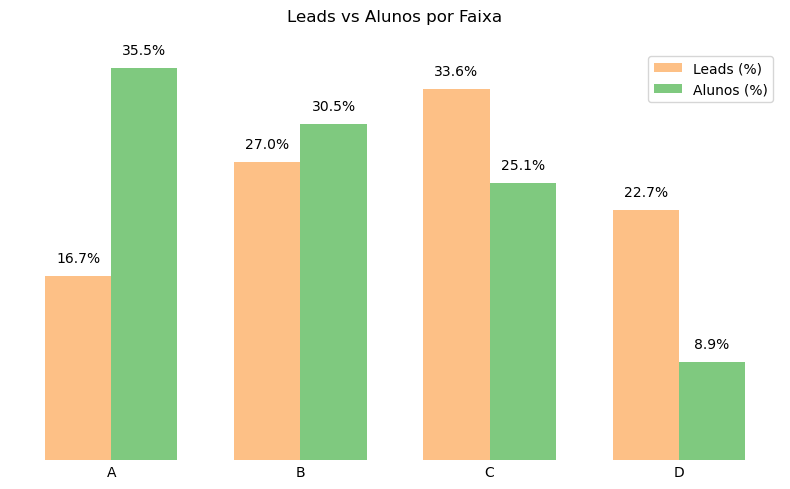

In [22]:
plot_comparativo_leads_alunos(df_leads, df_alunos)

In [23]:
# 1. Contagem por faixa
contagem = (
    df_leads.groupby(["lancamentos", "leadscore_faixa"], observed=True)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)
media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
,2718,17.0,4379,27.4,5430,34.0,3439,21.5,359.01
SSP-L12,2681,17.1,4352,27.8,5152,32.9,3454,22.1,358.24
SSP-L13,1617,15.4,2630,25.1,3574,34.1,2652,25.3,348.52


In [24]:
# 1. Contagem por faixa
contagem = (
    df_alunos.groupby(["lancamentos", "leadscore_faixa"], observed=False)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)

media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
,24,42.1,15,26.3,12,21.1,6,10.5,359.01
SSP-L12,45,32.4,45,32.4,37,26.6,12,8.6,358.24
SSP-L13,3,42.9,2,28.6,2,28.6,0,0.0,348.52


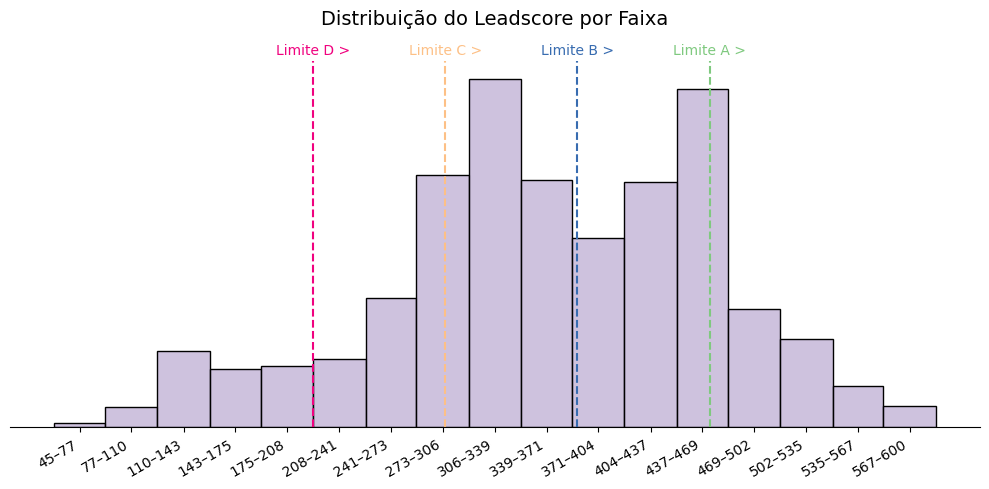

In [25]:
plot_histograma_leadscore(df_leads, limite_a, limite_b, limite_c, limite_d)

In [26]:
# Seleciona leads com faixa A ou B
leads_quentes = df_leads[df_leads["leadscore_faixa"].isin(["A", "B"])]
total_quentes = leads_quentes.shape[0]

# Quantos desses já compraram
compraram_quentes = leads_quentes["comprou"].sum()

# Resultado
print(f"Leads classificados como A ou B: {total_quentes}")
print(f"Desses, já compraram: {compraram_quentes}")
print(f"Ainda não compraram: {total_quentes - compraram_quentes}")

Leads classificados como A ou B: 18377
Desses, já compraram: 134
Ainda não compraram: 18243


In [27]:
from IPython.display import display
import pandas as pd

# --- Garantir datas e filtro base ---
df_leads['data'] = pd.to_datetime(df_leads['data'], errors='coerce')
data_minima = pd.Timestamp("2025-04-30")

df_filtrado = df_leads[
    (df_leads['lancamentos'] == 'SSP-L13') &
    (df_leads['data'] >= data_minima)
].copy()

# --- Gerar utm_combo sem utm_source ---
colunas_utm_sem_source = ["utm_campaign", "utm_medium", "utm_content"]
df_filtrado["utm_combo"] = df_filtrado[colunas_utm_sem_source] \
    .applymap(lambda x: '' if pd.isna(x) or str(x).strip().lower() == "nan" else str(x).strip()) \
    .agg(' | '.join, axis=1)

# --- Agrupar por utm_source e exibir cada bloco ---
utm_sources_unicos = df_filtrado['utm_source'].dropna().unique()

for utm_src in sorted(utm_sources_unicos):
    df_grupo = df_filtrado[df_filtrado['utm_source'] == utm_src]

    # Contagem absoluta
    dist = df_grupo.groupby(['utm_combo', 'leadscore_faixa']).size().unstack(fill_value=0)
    dist["Total"] = dist.sum(axis=1)

    # Percentuais por linha
    percent = (dist.drop(columns="Total").T / dist["Total"]).T * 100

    # Combinar número e percentual
    combinado = dist.drop(columns="Total").astype(str) + " (" + percent.round(1).astype(str) + "%)"
    combinado["Total"] = dist["Total"]

    # Linha TOTAL GERAL
    soma_col = dist.sum()
    linha_total = soma_col.drop("Total").astype(int).astype(str) + " (" + \
                  (soma_col.drop("Total") / soma_col["Total"] * 100).round(1).astype(str) + "%)"
    linha_total["Total"] = int(soma_col["Total"])
    combinado.loc["TOTAL GERAL"] = linha_total

    # Exibir tabela por grupo
    print(f"\n=== UTM_SOURCE: {utm_src} ===")
    display(combinado.sort_values(by="Total", ascending=False))


=== UTM_SOURCE: Facebook-Ads ===


C:\Users\Camilo_Bica\AppData\Local\Temp\ipykernel_24808\2236310325.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: '' if pd.isna(x) or str(x).strip().lower() == "nan" else str(x).strip()) \


leadscore_faixa,A,B,C,D,Total
utm_combo,,,,,
TOTAL GERAL,1384 (15.2%),2229 (24.5%),3128 (34.4%),2356 (25.9%),9097
SSP-L13 | CAPTACAO | CBO | FRIO | ALL | BR | 30-05-25 | Lookalike e Interesses | 00 | AUTO | LAL | 1% | INTIATE CHECKOUT | 180D | ADS_VID_002_ANUNCIO PETRO 02,339 (14.1%),583 (24.3%),878 (36.5%),604 (25.1%),2404
SSP-L13 | CAPTACAO | CBO | FRIO | ALL | BR | 30-05-25 | Lookalike e Interesses | 00 | AUTO | LAL | 1% | ENVOLVIMENTO IG | 30D | ADS_VID_002_ANUNCIO PETRO 02,230 (15.1%),330 (21.7%),498 (32.7%),465 (30.5%),1523
SSP-L13 | CAPTACAO | CBO | FRIO | ALL | BR | 30-05-25 | Lookalike e Interesses | 00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D | ADS_VID_002_ANUNCIO PETRO 02,167 (13.4%),286 (23.0%),439 (35.3%),351 (28.2%),1243
SSP-L13 | CAPTACAO | CBO | QUENTE | ALL | BR | 30-04-2025 | ENVOLVIMENTO | 00 | AUTO | ENVOLVIMENTO | 90D | ADS_VID_006_ANUNCIO PETRO 06,69 (16.6%),108 (26.0%),134 (32.2%),105 (25.2%),416
SSP-L13 | CAPTACAO | CBO | QUENTE | ALL | BR | 30-04-2025 | ENVOLVIMENTO | 00 | AUTO | ENVOLVIMENTO | 30D | ADS_VID_002_ANUNCIO PETRO 02,57 (13.9%),97 (23.6%),143 (34.8%),114 (27.7%),411
SSP-L13 | CAPTACAO | CBO | FRIO | ALL | BR | 30-05-25 | Lookalike e Interesses | 00 | AUTO | LAL | 1% | LEADS SSP - L12 | ADS_VID_002_ANUNCIO PETRO 02,67 (16.6%),92 (22.8%),149 (36.9%),96 (23.8%),404
SSP-L13 | CAPTACAO | CBO | QUENTE | ALL | BR | 30-04-2025 | ENVOLVIMENTO | 00 | AUTO | ENVOLVIMENTO | 90D | ADS_VID_002_ANUNCIO PETRO 02,63 (17.2%),95 (26.0%),124 (33.9%),84 (23.0%),366
SSP-L13 | CAPTACAO | CBO | FRIO | ALL | BR | 30-05-25 | Lookalike e Interesses | 00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D | ADS_VID_002_ANUNCIO PETRO 02,43 (12.4%),78 (22.5%),122 (35.3%),103 (29.8%),346



=== UTM_SOURCE: Instagram ===


leadscore_faixa,A,B,C,D,Total
utm_combo,,,,,
TOTAL GERAL,124 (16.5%),219 (29.2%),242 (32.3%),165 (22.0%),750
| Stories |,113 (16.4%),197 (28.6%),225 (32.7%),153 (22.2%),688
| Bio |,11 (17.7%),22 (35.5%),17 (27.4%),12 (19.4%),62



=== UTM_SOURCE: Tiktok ===


leadscore_faixa,A,B,C,D,Total
utm_combo,,,,,
| Bio |,13 (22.4%),12 (20.7%),19 (32.8%),14 (24.1%),58
TOTAL GERAL,13 (22.4%),12 (20.7%),19 (32.8%),14 (24.1%),58



=== UTM_SOURCE: Youtube ===


leadscore_faixa,A,B,C,D,Total
utm_combo,,,,,
| Descricao |,32 (25.4%),34 (27.0%),38 (30.2%),22 (17.5%),126
TOTAL GERAL,32 (25.4%),34 (27.0%),38 (30.2%),22 (17.5%),126



=== UTM_SOURCE: awsales ===


leadscore_faixa,C,Total
utm_combo,,
| |,1 (100.0%),1
TOTAL GERAL,1 (100.0%),1


In [28]:
"""
Esse bloco monta um modelo de classificação binária para prever a probabilidade de conversão de leads, com:

- Entrada: Perfil e respostas do lead
- Saída: Chance de virar aluno
- Algoritmo: Gradient Boosting
- Métrica usada: ROC AUC
"""

features_leads = [
    "renda",
    "escolaridade",
    "idade",
    "nível",
    "situação profissional"
]

# One-hot encoding
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Modelo
modelo_class = GradientBoostingClassifier(random_state=42)
modelo_class.fit(X_train, y_train)

# Avaliação
roc_auc = roc_auc_score(y_test, modelo_class.predict_proba(X_test)[:, 1])
print(f"ROC AUC (possível comprador): {roc_auc:.3f}")

# (Opcional) Score de probabilidade
df_leads["probabilidade_conversao_modelo"] = modelo_class.predict_proba(X)[:, 1]

ROC AUC (possível comprador): 0.727


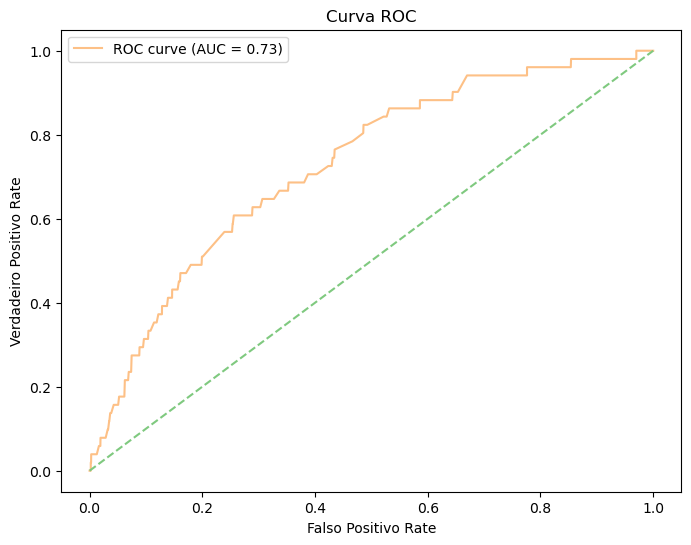

,Threshold,Precision,Recall,F1 Score
2,0.040816,0.032,0.039,0.035
1,0.020408,0.018,0.078,0.030
3,0.061224,0.034,0.020,0.025
0,0.000000,0.005,1.000,0.010
48,0.979592,0.000,0.000,0.000
47,0.959184,0.000,0.000,0.000
28,0.571429,0.000,0.000,0.000
29,0.591837,0.000,0.000,0.000
30,0.612245,0.000,0.000,0.000
31,0.632653,0.000,0.000,0.000


In [29]:
# Certifique-se de ter X_test, y_test e modelo treinado
probs = modelo_class.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, probs):.2f})", color=cores[2])
plt.plot([0, 1], [0, 1], linestyle="--", color=cores[0])
plt.xlabel("Falso Positivo Rate")
plt.ylabel("Verdadeiro Positivo Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(False)
plt.show()

# Avaliação para thresholds de 0.0 até 1.0
thresholds_to_test = np.linspace(0, 1, 50)
metrics = []

for thresh in thresholds_to_test:
    y_pred = (probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    metrics.append((thresh, precision, recall, f1))

# Mostrar tabela de avaliação
df_thresholds = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1 Score"])
df_thresholds["F1 Score"] = df_thresholds["F1 Score"].round(3)
df_thresholds["Precision"] = df_thresholds["Precision"].round(3)
df_thresholds["Recall"] = df_thresholds["Recall"].round(3)
df_thresholds.sort_values("F1 Score", ascending=False).head(10)

In [30]:
"""
Você poderá usar esse modelo para prever o score mesmo para leads que não constam no score_map ou para variáveis novas.
Também ajuda a testar consistência entre o modelo treinado e o score heurístico que você aplicou com base nos lifts.
"""

# Preparo dos dados
X_reg = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
y_reg = df_alunos["leadscore_mapeado"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, random_state=42)

# Modelo de regressão
modelo_reg = GradientBoostingRegressor(random_state=42)
modelo_reg.fit(X_train_r, y_train_r)

# Avaliação
y_pred_r = modelo_reg.predict(X_test_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
mae_pct = (mae / y_test_r.mean()) * 100

print(f"R² (leadscore_mapeado): {r2:.2f}")
print(f"Erro médio absoluto (MAE): {mae:.2f}")
print(f"MAE percentual: {mae_pct:.2f}%")

R² (leadscore_mapeado): 0.99
Erro médio absoluto (MAE): 6.51
MAE percentual: 1.55%


In [31]:
# Previsão nos leads
X_leads = pd.get_dummies(df_leads[features_alunos], drop_first=False)
X_leads = X_leads.reindex(columns=X_reg.columns, fill_value=0)

# Gerar leadscore estimado contínuo
df_leads["leadscore_regressao"] = modelo_reg.predict(X_leads).round(2)

# Visualizar os top leads por score estimado
df_leads.drop(columns=['email']).head(10)

,data,idade,nível,situação profissional,renda,escolaridade,duvida,dificuldade,utm_source,utm_campaign,utm_medium,utm_content,lancamentos,comprou,leadscore_mapeado,leadscore_faixa,probabilidade_conversao_modelo,leadscore_regressao
0,2025-04-07,33-37,Técnica,Autônomo,De 1.000 a 3.000,Ensino médio completo,O que preciso pra ser aprovado,Tempo,,,,,,0,337.70,C,0.002501,339.80
1,2025-04-07,23-27,Técnica,Desempregado(a),Estou desempregado(a),Ensino superior incompleto,.,Separa material,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_001_ANUNCIO PETRO 01,SSP-L12,0,315.41,C,0.026764,317.49
2,2025-04-07,18-22,Superior,Desempregado(a),Estou desempregado(a),Ensino médio completo,O quão difícil é conseguir passar,Nenhuma,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,SSP-L12,0,123.19,D,0.000935,142.77
3,2025-04-07,28-32,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Em qual lugar do Brasil pode fazer o concurso?,Tempo,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 30D,ADS_001_ANUNCIO PETRO 01,SSP-L12,0,368.56,C,0.011341,368.01
4,2025-04-07,18-22,Técnica,Autônomo,Estou desempregado(a),Ensino médio completo,Se precisa de ensino superior,Nenhuma,,,,,,0,278.94,D,0.002731,312.34
5,2025-04-07,46-52,Técnica,Desempregado(a),Estou desempregado(a),Ensino superior completo,Legislação,Memória,,,,,,0,400.94,B,0.007699,399.58
6,2025-04-07,33-37,Técnica,Funcionário de empresa privada,De 1.000 a 3.000,Ensino médio completo,Como vou conseguir?,Tempo,Instagram,,Bio,,SSP-L12,0,442.51,B,0.003636,445.58
7,2025-04-07,23-27,Técnica,Desempregado(a),Estou desempregado(a),Nível técnico completo,Sobre oque vai cair e se precisa de redação,Nenhuma,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | QUENTE | ALL | BR |...,00 | AUTO | ENVOLVIMENTO | 90D,ADS_006_ANUNCIO PETRO 06,SSP-L12,0,391.71,B,0.009308,380.82
8,2025-04-07,23-27,Superior,Desempregado(a),De 0 a 1.000,Ensino superior incompleto,Como estudar,Concentração,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 7D,ADS_001_ANUNCIO PETRO 01,SSP-L12,0,141.17,D,0.009899,137.56
9,2025-04-07,28-32,Técnica,Autônomo,De 1.000 a 3.000,Nível técnico completo,Mudança de vida,Tempo,Facebook-Ads,SSP-L12 | CAPTACAO | CBO | FRIO | ALL | BR | 3...,00 | AUTO | LAL | 1% | ENVOLVIMENTO IG 14D,ADS_001_ANUNCIO PETRO 01,SSP-L12,0,385.40,B,0.005907,379.43


In [32]:
# Validar se o modelo de regressão estima bem as faixas reais dos alunos

# 1. Copiar info de score real e faixa real
df_avaliacao = df_alunos[["email", "leadscore_mapeado", "leadscore_faixa"]].copy()

# 2. Gerar os X para regressão (features iguais às usadas no modelo)
X_alunos = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
X_alunos = X_alunos.reindex(columns=X_reg.columns, fill_value=0)

# 3. Aplicar o modelo de regressão
df_avaliacao["leadscore_regressao"] = modelo_reg.predict(X_alunos)

# 4. Classificar usando a função baseada na média dos alunos
df_avaliacao["faixa_regressao"] = df_avaliacao["leadscore_regressao"].apply(classificar_faixa)

# 5. Ver a matriz de confusão real x predita
comparativo = df_avaliacao.groupby(["leadscore_faixa", "faixa_regressao"]).size().unstack(fill_value=0)

display(comparativo)

faixa_regressao,A,B,C,D
leadscore_faixa,,,,
A,71,1,0,0
B,0,59,3,0
C,0,4,46,1
D,0,0,0,18


In [33]:
# Juntar as bases
comparacao = df_leads.merge(
    df_alunos,
    on="email",
    suffixes=("_lead", "_aluno")
)

# Verificar onde as respostas foram diferentes
mudancas = {}
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Convertendo para string para evitar erro de comparação entre categoricals com categorias diferentes
        diferentes = (comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)).sum()
        total = comparacao.shape[0]
        mudancas[var] = round((diferentes / total) * 100, 1)
    else:
        mudancas[var] = None  # Ou 0, ou continue

# Transformar em DataFrame para exibição
df_mudancas = pd.DataFrame.from_dict(mudancas, orient="index", columns=["% Respostas Diferentes"])
df_mudancas = df_mudancas.dropna().sort_values(by="% Respostas Diferentes", ascending=False)

df_mudancas

,% Respostas Diferentes
renda,0.0
escolaridade,0.0
idade,0.0
nível,0.0
situação profissional,0.0


In [34]:
# Para cada variável comum, mostrar diferenças
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Comparação como string para evitar erros com categorias
        diferentes = comparacao[comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)]
        total = comparacao.shape[0]

        print(f"\n🔍 {len(diferentes)} de {total} respostas são diferentes em '{var}'")
        display(diferentes[["email", col_lead, col_aluno]].head(10))
    else:
        print(f"\n⚠️ Coluna '{var}' não encontrada em ambos os DataFrames.")


🔍 0 de 213 respostas são diferentes em 'renda'


,email,renda_lead,renda_aluno



🔍 0 de 213 respostas são diferentes em 'escolaridade'


,email,escolaridade_lead,escolaridade_aluno



🔍 0 de 213 respostas são diferentes em 'idade'


,email,idade_lead,idade_aluno



🔍 0 de 213 respostas são diferentes em 'nível'


,email,nível_lead,nível_aluno



🔍 0 de 213 respostas são diferentes em 'situação profissional'


,email,situação profissional_lead,situação profissional_aluno


In [35]:
"""
Esse modelo é o coração da previsão de probabilidade de conversão. E ele tem duas grandes vantagens:

1. Calibração com pesos → ajuda a lidar com o desbalanceamento real
2. Integração com o score → junta perfil sociodemográfico + quão parecido o lead é com os alunos
"""

# Preparar X e y
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
X["leadscore_mapeado"] = df_leads["leadscore_mapeado"]  # Adiciona o score final como feature
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

modelo_calibrado = GradientBoostingClassifier(random_state=42)
modelo_calibrado.fit(X_train, y_train, sample_weight=sample_weight)

# Score calibrado com base nas duas fontes
df_leads["probabilidade_conversao_modelo"] = modelo_calibrado.predict_proba(X)[:, 1]

# Avaliação
print("ROC AUC:", roc_auc_score(y_test, modelo_calibrado.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, modelo_calibrado.predict(X_test)))

ROC AUC: 0.6245067135651663
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     10469
           1       0.01      0.45      0.02        51

    accuracy                           0.76     10520
   macro avg       0.50      0.61      0.44     10520
weighted avg       0.99      0.76      0.86     10520



In [36]:
# Inicializar o scaler
scaler = MinMaxScaler()

# Normalizar os dois componentes separadamente
leadscore_normalizado = scaler.fit_transform(df_leads[["leadscore_regressao"]]).flatten()
probabilidade_normalizada = scaler.fit_transform(df_leads[["probabilidade_conversao_modelo"]]).flatten()

# Pesos (ajustáveis)
peso_score = 0.5
peso_prob = 0.5

# Calcular o score híbrido como média ponderada dos valores normalizados
df_leads["score_hibrido"] = (
    peso_score * leadscore_normalizado +
    peso_prob * probabilidade_normalizada
).round(4)

# Opcional: ordenar para inspeção
df_leads = df_leads.sort_values("score_hibrido", ascending=False)

# Exibir os 10 primeiros leads rankeados
display(df_leads[["email", "leadscore_regressao", "leadscore_faixa", "probabilidade_conversao_modelo", "score_hibrido"]].drop(columns=['email']).head(10))

,leadscore_regressao,leadscore_faixa,probabilidade_conversao_modelo,score_hibrido
41321,574.96,A,0.837136,0.9331
38786,574.96,A,0.837136,0.9331
6819,574.96,A,0.837136,0.9331
19675,574.96,A,0.837136,0.9331
8612,574.96,A,0.837136,0.9331
22454,574.96,A,0.837136,0.9331
1501,574.96,A,0.837136,0.9331
25172,574.96,A,0.837136,0.9331
6736,574.96,A,0.837136,0.9331
38249,574.96,A,0.837136,0.9331


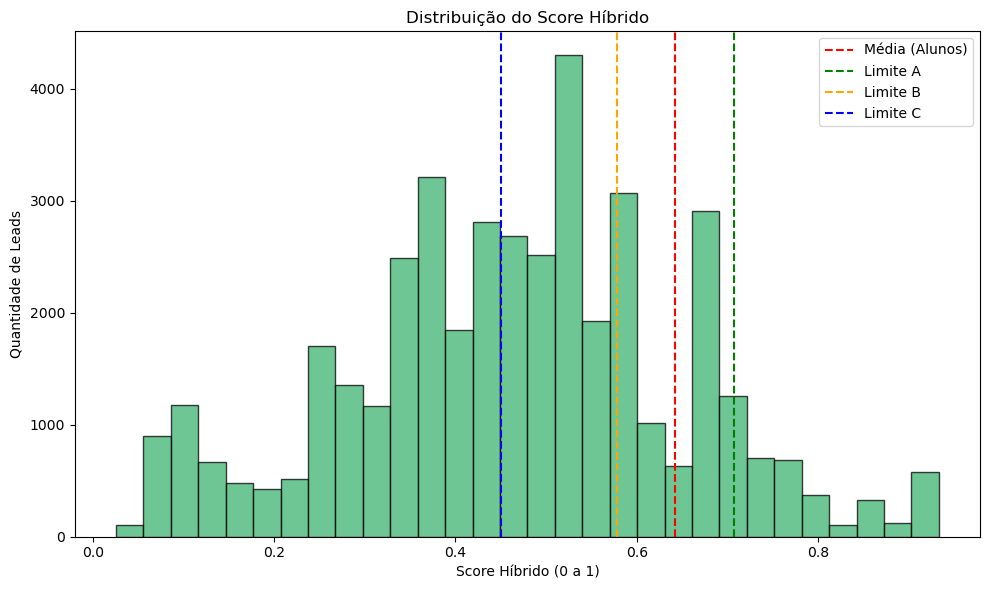

,Total Leads,Alunos,Taxa de Conversão (%)
faixa_score_hibrido,,,
A,3345,73,2.2%
B,6768,52,0.8%
C,13097,54,0.4%
D,18868,24,0.1%


In [37]:
# Base de referência: score_hibrido dos ALUNOS
media_hibrido_alunos = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean()

# Limiares baseados na média dos alunos
limite_A = media_hibrido_alunos * 1.10
limite_B = media_hibrido_alunos * 0.90
limite_C = media_hibrido_alunos * 0.70

# Função de classificação
def classificar_faixa_hibrida(score):
    if score >= limite_A:
        return "A"
    elif score >= limite_B:
        return "B"
    elif score >= limite_C:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["faixa_score_hibrido"] = df_leads["score_hibrido"].apply(classificar_faixa_hibrida)

# Plotar histograma do score_hibrido
plt.figure(figsize=(10, 6))
plt.hist(df_leads["score_hibrido"], bins=30, color="mediumseagreen", edgecolor="black", alpha=0.75)
plt.axvline(media_hibrido_alunos, color="red", linestyle="--", label="Média (Alunos)")
plt.axvline(limite_A, color="green", linestyle="--", label="Limite A")
plt.axvline(limite_B, color="orange", linestyle="--", label="Limite B")
plt.axvline(limite_C, color="blue", linestyle="--", label="Limite C")

plt.title("Distribuição do Score Híbrido")
plt.xlabel("Score Híbrido (0 a 1)")
plt.ylabel("Quantidade de Leads")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Gerar tabela de faixas com base na nova coluna faixa_score_hibrido
tabela_faixas_hibrido = (
    df_leads
    .groupby("faixa_score_hibrido")["comprou"]
    .agg(["count", "sum", "mean"])
    .rename(columns={
        "count": "Total Leads", 
        "sum": "Alunos", 
        "mean": "Taxa de Conversão"
    })
    .sort_index()
    .round(4)
)

# Formatar a taxa de conversão como string percentual
tabela_faixas_hibrido["Taxa de Conversão (%)"] = (
    tabela_faixas_hibrido["Taxa de Conversão"] * 100
).round(1).astype(str) + "%"

# Opcional: remover coluna bruta
tabela_faixas_hibrido = tabela_faixas_hibrido.drop(columns="Taxa de Conversão")

# Exibir resultado
display(tabela_faixas_hibrido)

In [38]:
# Calcular média do score híbrido por lançamento
media_hibrido_por_lancamento = (
    df_leads.groupby("lancamentos", observed=True)["score_hibrido"]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={"score_hibrido": "Probabilidade Relativa (0 - 1)"})
)

display(media_hibrido_por_lancamento)

,lancamentos,Probabilidade Relativa (0 - 1)
0,,0.47
1,SSP-L12,0.47
2,SSP-L13,0.45


In [39]:
# Agrupamento por lançamento
tabela_lancamentos_avancada = df_leads.groupby("lancamentos", observed=True).agg(
    total_leads=("email", "count"),
    compras_reais=("comprou", "sum"),
    score_hibrido_medio=("score_hibrido", "mean"),
    probabilidade_media_modelo=("probabilidade_conversao_modelo", "mean"),
    taxa_real_conversao=("comprou", "mean")  # 0 = não comprou, 1 = comprou
).reset_index()

# Formatando colunas
tabela_lancamentos_avancada["score_hibrido_medio"] = tabela_lancamentos_avancada["score_hibrido_medio"].round(2)
tabela_lancamentos_avancada["probabilidade_media_modelo"] = (tabela_lancamentos_avancada["probabilidade_media_modelo"]).round(2)
tabela_lancamentos_avancada["taxa_real_conversao (%)"] = (tabela_lancamentos_avancada["taxa_real_conversao"] * 100).round(2)

# Selecionar colunas finais
tabela_lancamentos_avancada = tabela_lancamentos_avancada[[
    "lancamentos",
    "total_leads",
    "compras_reais",
    "taxa_real_conversao (%)",
    "probabilidade_media_modelo",
    "score_hibrido_medio"
]]

# Exibir resultado
display(tabela_lancamentos_avancada)

,lancamentos,total_leads,compras_reais,taxa_real_conversao (%),probabilidade_media_modelo,score_hibrido_medio
0,,15966,57,0.36,0.36,0.47
1,SSP-L12,15639,139,0.89,0.37,0.47
2,SSP-L13,10473,7,0.07,0.34,0.45


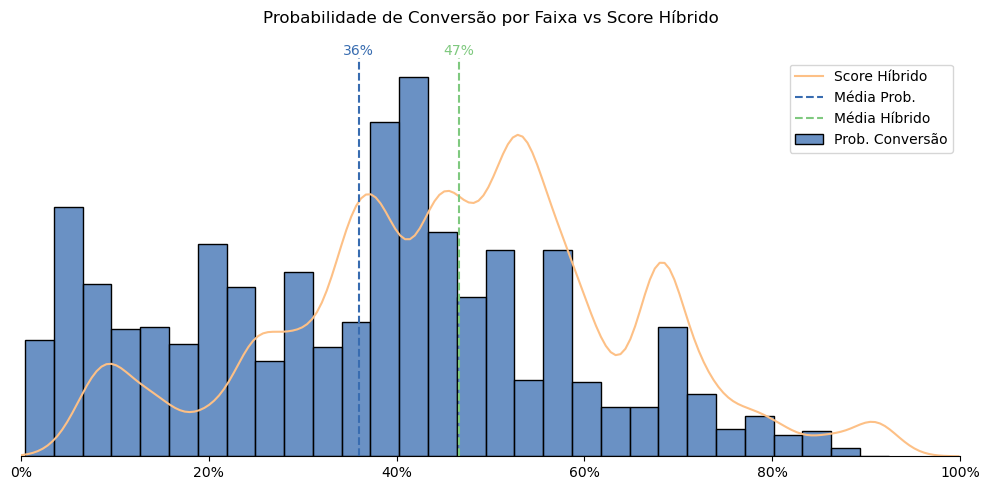

In [40]:
plot_probabilidade_conversao_vs_score(df_leads)

In [41]:
# Gerar a tabela cruzada real x predita com leads que viraram alunos
df_compare = df_leads[df_leads["email"].isin(df_alunos["email"])][["email", "faixa_score_hibrido"]]
df_compare = df_compare.merge(
    df_alunos[["email", "leadscore_faixa"]],
    on="email"
)

# Tabela cruzada: faixa real (aluno) vs faixa predita (modelo híbrido)
comparativo_faixa = pd.crosstab(df_compare["leadscore_faixa"], df_compare["faixa_score_hibrido"])

# Calcular Cramér’s V com essa matriz
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Calcular e imprimir
cramers_v_score = cramers_v(comparativo_faixa)
print(f"Cramér’s V: {cramers_v_score:.3f} (0 = sem associação, 1 = associação perfeita)")

Cramér’s V: 0.480 (0 = sem associação, 1 = associação perfeita)


In [42]:
# Caminho direto para a pasta 'modelos'
path_modelos = Path("C:/Users/Camilo_Bica/data_science/consultoria/acelerador_petrobras/modelos")
path_modelos.mkdir(parents=True, exist_ok=True)

# Média dos compradores (referência para benchmarking)
media_compradores = df_alunos["leadscore_mapeado"].mean()

# 1. Modelo de regressão para prever leadscore
joblib.dump(modelo_reg, path_modelos / "modelo_regressao_leadscore_total.pkl")
joblib.dump(X_reg.columns.tolist(), path_modelos / "colunas_regressao.pkl")

# 2. Limites para classificar em faixas A, B, C, D
limites = {
    "media_compradores": media_compradores,
    "limite_a": limite_a,
    "limite_b": limite_b,
    "limite_c": limite_c,
    "limite_d": limite_d
}
joblib.dump(limites, path_modelos / "limites_faixa.pkl")

joblib.dump(score_map, path_modelos / "score_map.pkl")

# 3. Modelo de classificação calibrado para prever conversão
joblib.dump(modelo_calibrado, path_modelos / "modelo_conversao_calibrado.pkl")
joblib.dump(X.columns.tolist(), path_modelos / "colunas_modelo_conversao_calibrado.pkl")

tabelas_lift = {}
for feature in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, feature)
    tabelas_lift[feature] = tabela

joblib.dump(tabelas_lift, path_modelos / "tabelas_lift.pkl")

# 4. Confirmação
print("✅ Modelos e arquivos de configuração exportados para:", path_modelos)

✅ Modelos e arquivos de configuração exportados para: C:\Users\Camilo_Bica\data_science\consultoria\acelerador_petrobras\modelos


In [43]:
from gspread_dataframe import set_with_dataframe
from datetime import datetime

# Carrega as variáveis de ambiente
load_dotenv()

# Pega o caminho de forma segura
credenciais_path = os.getenv("GOOGLE_CREDENTIALS_PATH")

# === Escopos de acesso ===
scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

# === Autenticar ===
creds = service_account.Credentials.from_service_account_file(
    credenciais_path,
    scopes=scopes
)
client = gspread.authorize(creds)

# === Função para criar nova planilha e carregar dados ===
def criar_planilha_e_enviar(df, nome_base):
    nome_final = nome_base
    
    # Cria nova planilha
    planilha = client.create(nome_final)
    
    # Compartilha com seu e-mail pessoal (aqui você coloca o seu)
    planilha.share('camilobf2@gmail.com', perm_type='user', role='writer')  # <<< Trocar pelo seu email do Gmail

    # Preenche a primeira aba
    aba = planilha.sheet1
    aba.update_title("Dados")
    set_with_dataframe(aba, df)
    
    print(f"✅ Nova planilha criada: {nome_final}")
    print(f"🔗 Link: https://docs.google.com/spreadsheets/d/{planilha.id}/edit")

# === Geração dos arquivos ===
#criar_planilha_e_enviar(df_alunos, "leadscore_implementado")

In [44]:
# === Função para atualizar uma planilha existente ===
def atualizar_planilha_existente(df: pd.DataFrame, sheet_id: str, aba_nome: str = "Dados"):
    """
    Atualiza uma aba específica de uma planilha no Google Sheets.
    
    - df: DataFrame com os dados que serão enviados
    - sheet_id: ID da planilha (o que vem na URL depois de "/d/")
    - aba_nome: Nome da aba que será atualizada (default: 'Dados')
    """
    try:
        planilha = client.open_by_key(sheet_id)
        try:
            aba = planilha.worksheet(aba_nome)
        except gspread.WorksheetNotFound:
            aba = planilha.add_worksheet(title=aba_nome, rows="1000", cols="20")
        
        aba.clear()  # Limpa dados antigos
        set_with_dataframe(aba, df)
        
        print(f"✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/{sheet_id}/edit")
    except Exception as e:
        print(f"❌ Erro ao atualizar a planilha: {e}")

# === IDs das planilhas (FIXOS, preencha certinho aqui) ===
id_leads = "1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc"
id_alunos = "15RQf1wkiafPZftolCIAwcTFE7rv0_zRTB0zDOCkdPRs"

# === Atualizar todas as planilhas ===
atualizar_planilha_existente(df_leads, id_leads)
atualizar_planilha_existente(df_alunos, id_alunos)

✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/1otpSf30y2iqykxNNiCmN3DjxVDTuHSVZhOpzwi8UBBc/edit


✅ Planilha atualizada: https://docs.google.com/spreadsheets/d/15RQf1wkiafPZftolCIAwcTFE7rv0_zRTB0zDOCkdPRs/edit
